In [1]:
import pickle
import os

ROOT_DIR = "/kld/"

# input type
ORIGINAL = "original"
AUDIO = "audio"
ORIGINAL_AUDIO = "original_and_audio"
IPA = "ipa"
IPA_AUDIO = "ipa_and_audio"

# word group
# COMMON = "common"
# RARE = "raret"
CONSTRUCTED = "constructed"

# key
# HIDDEN_STATES = "hidden_states"
# MLP_STATES = "mlp_states"
# ATTN_STATES = "attn_states"
PROBS = "prob"
LOGITS = "logits"
layer_type_list = [PROBS, LOGITS]

dim_list = [
    "good", # 0
    "beautiful",
    "pleasant",
    "strong",
    "big",
    "rugged",
    "active",
    "fast",
    "sharp",
    "realistic",
    "structured",
    "ordinary",
    "interesting",
    "simple",
    "abrupt",
    "exciting",
    "hard",
    "happy",
    "harsh",
    "heavy",
    "inhibited",
    "masculine",
    "solid",
    "tense",
    "dangerous"
]


high_score_dim_list = [
    'big', 
    'tense',
    'ordinary', 
    'sharp',
    'simple',
    'harsh'
    ]
low_score_dim_list = ["fast", "exciting", "hard", "solid", "strong", "realistic"]
highest = ["big"]
lowest = ["realistic"]
# 

In [2]:
def load_pickle_file(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

def load_hidden_states(input_type, word_group, dim):
    file_path = os.path.join(ROOT_DIR, f"{input_type}_{word_group}_{dim}.pkl")
    return load_pickle_file(file_path)

def get_key_list(hiden_states_dict):
    return list(hiden_states_dict.keys())

def get_intersection_keys(f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio):
    original_key_list = get_key_list(f_original)
    audio_key_list = get_key_list(f_audio)
    original_audio_key_list = get_key_list(f_original_audio)
    ipa_key_list = get_key_list(f_ipa)
    ipa_audio_key_list = get_key_list(f_ipa_audio)
    
    return list(set(original_key_list) & set(audio_key_list) & set(original_audio_key_list) & set(ipa_key_list) & set(ipa_audio_key_list))

In [3]:
def update_dict(dict, new_dict):
    for key, value in new_dict.items():
        if key in dict:
            dict[key].update(value)
        else:
            dict[key] = value
    return dict

# merge the keywords by dimension 
def merge_keywords_by_dimension(dim_list):
    # inital
    f_original = load_hidden_states(ORIGINAL, CONSTRUCTED, dim_list[0])
    f_audio = load_hidden_states(AUDIO, CONSTRUCTED, dim_list[0])
    f_original_audio = load_hidden_states(ORIGINAL_AUDIO, CONSTRUCTED, dim_list[0])
    f_ipa = load_hidden_states(IPA, CONSTRUCTED, dim_list[0])
    f_ipa_audio = load_hidden_states(IPA_AUDIO, CONSTRUCTED, dim_list[0])
    intersection_keys = get_intersection_keys(f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio)

    for i in range(1, len(dim_list)):
        dim = dim_list[i]
        f_original_new = load_hidden_states(ORIGINAL, CONSTRUCTED, dim)
        f_audio_new = load_hidden_states(AUDIO, CONSTRUCTED, dim)
        f_original_audio_new = load_hidden_states(ORIGINAL_AUDIO, CONSTRUCTED, dim)
        f_ipa_new = load_hidden_states(IPA, CONSTRUCTED, dim)
        f_ipa_audio_new = load_hidden_states(IPA_AUDIO, CONSTRUCTED, dim)
        
        f_original = update_dict(f_original, f_original_new)
        f_audio = update_dict(f_audio, f_audio_new)
        f_original_audio = update_dict(f_original_audio, f_original_audio_new)
        f_ipa = update_dict(f_ipa, f_ipa_new)
        f_ipa_audio = update_dict(f_ipa_audio, f_ipa_audio_new)
        
        intersection_keys.extend(get_intersection_keys(f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio))
        
    return f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio, intersection_keys

In [4]:
dim_list = low_score_dim_list
f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio, intersection_keys = merge_keywords_by_dimension(dim_list)


In [ ]:
# get cos sim between two hidden states

import numpy as np


def get_kld(P, Q, epsilon=1e-10):
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)
    
    # Normalize along last axis in case inputs aren't already normalized
    P = P / (np.sum(P, axis=-1, keepdims=True) + epsilon)
    Q = Q / (np.sum(Q, axis=-1, keepdims=True) + epsilon)

    # Compute KL divergencesl
    x =  np.sum(P * np.log((P + epsilon) / (Q + epsilon)), axis=-1)
    
    return x


def get_kld_between_layers(vector_dict, key, layer_id_1, layer_id_2):
    pe_1_vec = vector_dict[key][layer_id_1][PROBS]
    pe_2_vec = vector_dict[key][layer_id_2][PROBS]
    
    return get_kld(pe_1_vec, pe_2_vec)
    

def get_kld_between_input_type(input_type_1_vec, input_type_2_vec, layer_id, key, value_type):
    return get_kld(input_type_1_vec[key][layer_id][value_type], input_type_2_vec[key][layer_id][value_type])


In [6]:
def calculate_kld_mean_btw_input_types(input_type_1, input_type_2, keys):
    probs = []
    for i in range(28):  # Assuming 28 layers
        kld_layers = []
        
        for key in keys:
            # Attention states
            kld = get_kld_between_input_type(input_type_1, input_type_2, i, key, PROBS)
            kld_layers.append(kld)
        
        # Calculate mean distance for each layer
        probs.append(np.mean(kld_layers))
    
    return {
        "probs": probs,
    }

    
def calculate_kld_mean_btw_layers_(input_type_vector, keys):
    kld_by_layers = []
    for i in range(28):  # Assuming 28 layers
        kld_layers = []
        
        for key in keys:
            # Attention states
            kld = get_kld_between_layers(input_type_vector, key, 27, i)
            kld_layers.append(kld)
        
        # Calculate mean distance for each layer
        print(len(kld_layers))
        kld_by_layers.append(np.mean(kld_layers))
    
    
    return {
        "kld": kld_by_layers,
    }


In [7]:
import matplotlib.pyplot as plt

def plot_mean_distances(distances, input_type_1_name, input_type_2_name):
    x = [i for i in range(28)]
    
    plt.figure(figsize=(12, 7))
    plt.plot(x, distances["probs"], label="probs", marker='o', linewidth=2)
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Mean Distance (1 - cosine similarity)', fontsize=12)
    plt.title(f'Mean Distance Between {input_type_1_name} and {input_type_2_name} Representations', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [8]:
# Additional example: Compare all possible pairs
pairs = [
    (f_original, f_audio, "Original", "Audio"),
    (f_audio, f_original, "Audio", "Original"),
    (f_original, f_ipa, "Original", "IPA"),
    (f_ipa, f_original, "IPA", "Original"),
    (f_original, f_original_audio, "Original", "Original+Audio"),
    (f_original_audio, f_original, "Original+Audio", "Original"),
    (f_original, f_ipa_audio, "Original", "IPA+Audio"),
    (f_ipa_audio, f_original, "IPA+Audio", "Original"),
    (f_audio, f_ipa, "Audio", "IPA"),
    (f_ipa, f_audio, "IPA", "Audio"),
    (f_audio, f_original_audio, "Audio", "Original+Audio"),
    (f_original_audio, f_audio, "Original+Audio", "Audio"),
    (f_audio, f_ipa_audio, "Audio", "IPA+Audio"),
    (f_ipa_audio, f_audio, "IPA+Audio", "Audio"),
    (f_ipa, f_original_audio, "IPA", "Original+Audio"),
    (f_original_audio, f_ipa, "Original+Audio", "IPA"),
    (f_ipa, f_ipa_audio, "IPA", "IPA+Audio"),
    (f_original, f_ipa_audio, "Original", "IPA+Audio"),
    (f_original_audio, f_ipa_audio, "Original+Audio", "IPA+Audio"),
    (f_ipa_audio, f_original_audio, "IPA+Audio", "Original+Audio")

]

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def do_plot(pairs, intersection_keys):
    num_plots = len(pairs)
    cols = 4
    rows = (num_plots + cols - 1) // cols  # ensures enough rows for all plots

    fig = plt.figure(figsize=(cols * 5, rows * 4))
    gs = GridSpec(rows, cols, figure=fig)
    ax_list = []

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = fig.add_subplot(gs[row, col])
        ax_list.append(ax)

    for i, (input_type_1, input_type_2, name_1, name_2) in enumerate(pairs):
        if i >= len(ax_list):
            break

        distances = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, intersection_keys)
        x = list(range(28))

        ax = ax_list[i]
        ax.plot(x, distances["probs"], label="probs", marker='o', markersize=3)

        ax.set_title(f"P: {name_1} || Q:  {name_2}", fontsize=10)
        ax.set_xlabel('Layer', fontsize=8)
        ax.set_ylabel('Distance', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if i == 0:
            ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# do_plot(pairs, intersection_keys)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

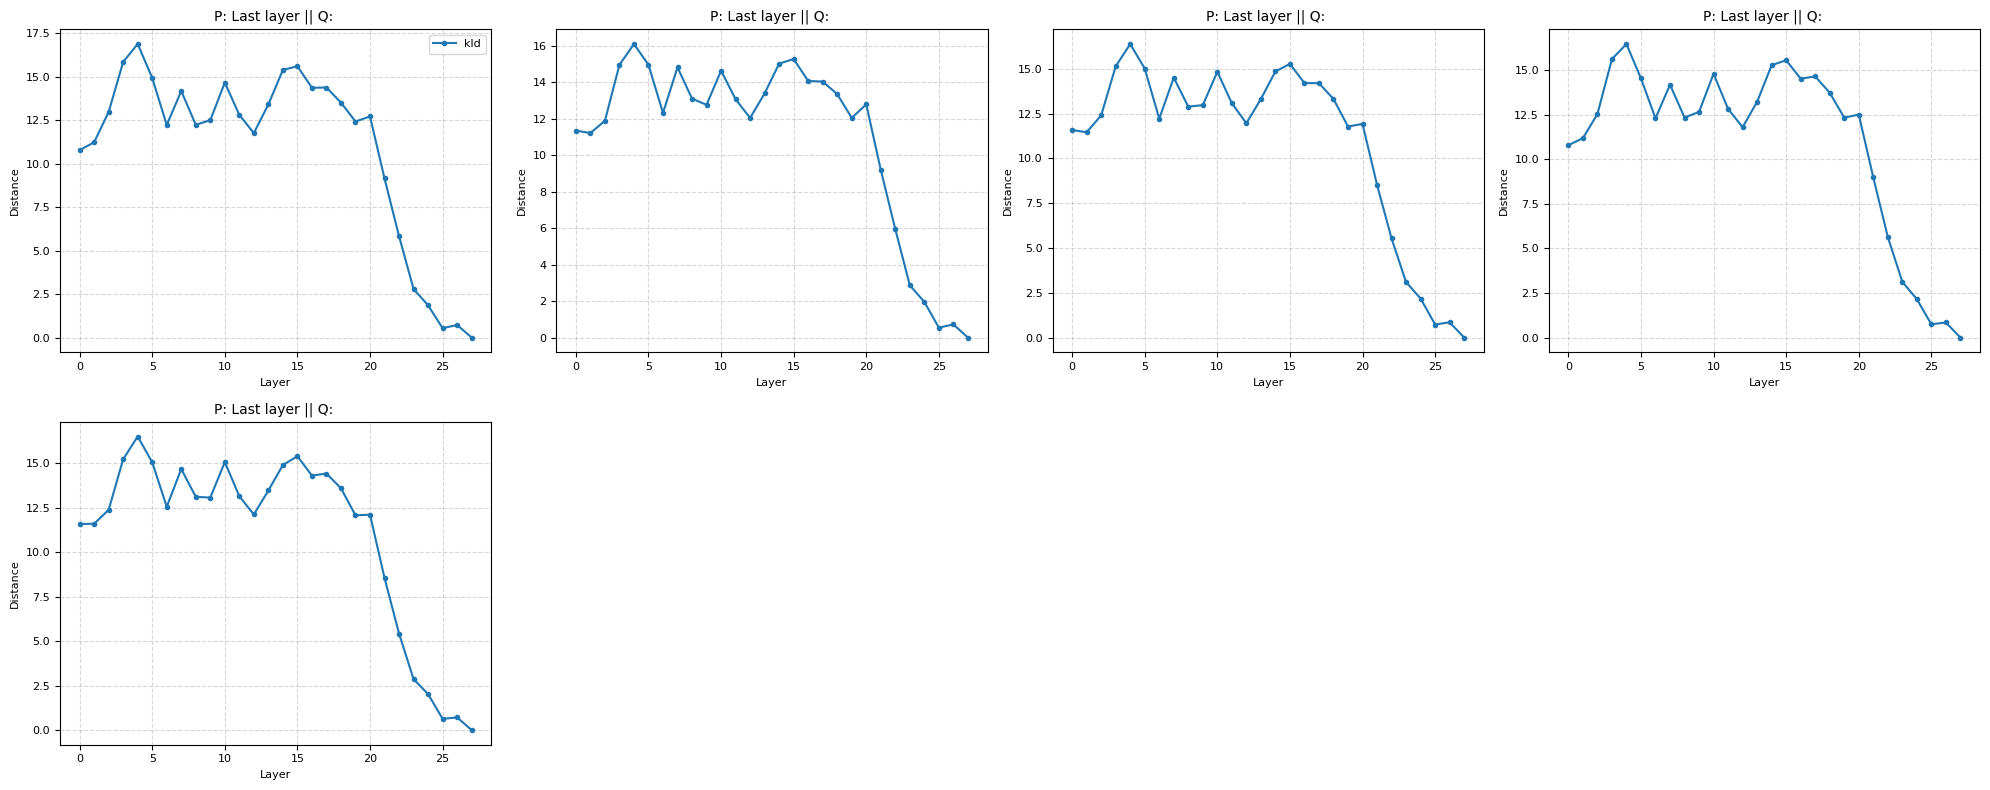

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def do_plot_btw_layers(intersection_keys, input_types):
    num_plots = len(input_types)
    cols = 4
    rows = (num_plots + cols - 1) // cols  # ensures enough rows for all plots

    fig = plt.figure(figsize=(cols * 5, rows * 4))
    gs = GridSpec(rows, cols, figure=fig)
    ax_list = []

    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = fig.add_subplot(gs[row, col])
        ax_list.append(ax)

    for i, input_type in enumerate(input_types):
        if i >= len(ax_list):
            break

        kld_list = calculate_kld_mean_btw_layers_(input_type, intersection_keys)
        x = list(range(len(kld_list["kld"])))  # adjust in case the layer count varies

        ax = ax_list[i]
        ax.plot(x, kld_list["kld"], label="kld", marker='o', markersize=3)

        ax.set_title(f"P: Last layer || Q: {""}", fontsize=10)
        ax.set_xlabel('Layer', fontsize=8)
        ax.set_ylabel('Distance', fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=8)

        if i == 0:
            ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

input_types = [f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio]
do_plot_btw_layers(intersection_keys, input_types)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

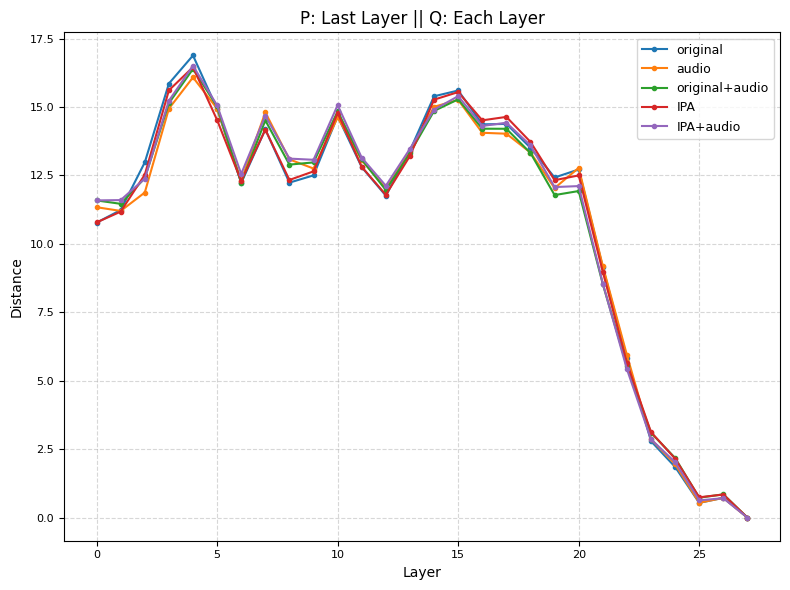

In [11]:
import matplotlib.pyplot as plt

def do_plot_btw_layers(intersection_keys, input_types, input_labels=None):
    if input_labels is None:
        input_labels = [f"Input {i}" for i in range(len(input_types))]

    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    for input_type, label in zip(input_types, input_labels):
        kld_list = calculate_kld_mean_btw_layers_(input_type, intersection_keys)
        x = list(range(len(kld_list["kld"])))
        y = [float(v) for v in kld_list["kld"]]  # ensure native float if needed

        ax.plot(x, y, label=label, marker='o', markersize=3)

    ax.set_title("P: Last Layer || Q: Each Layer", fontsize=12)
    ax.set_xlabel('Layer', fontsize=10)
    ax.set_ylabel('Distance', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.legend(fontsize=9)

    plt.tight_layout()
    plt.show()

input_types = [f_original, f_audio, f_original_audio, f_ipa, f_ipa_audio]
input_labels = ["original", "audio", "original+audio", "IPA", "IPA+audio"]

do_plot_btw_layers(intersection_keys, input_types, input_labels)

In [12]:
print(len(f_audio))

110


In [13]:
def plot_by_layer_type(layer_type, pairs, keys):
    """
    Plot all input type pairs for a specific layer type (MLP, hidden, or attention).
    
    Args:
        layer_type: String, one of "mlp", "hidden", or "attention"
        pairs: List of tuples (input_type_1, input_type_2, name_1, name_2)
        keys: List of keys to use for comparison
    """
    if layer_type.lower() not in [MLP_STATES, HIDDEN_STATES, ATTN_STATES]:
        raise ValueError("layer_type must be one of 'mlp', 'hidden', or 'attention'")
    
    # Map the layer_type string to the corresponding key in the distances dictionary
    layer_type_key = layer_type.lower()
    
    plt.figure(figsize=(14, 8))
    x = [i for i in range(28)]
    
    # Use different line styles and markers for different pairs
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'D', 'x', '+', '*', 'v', '>', '<']
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    
    for i, (input_type_1, input_type_2, name_1, name_2) in enumerate(pairs):
        distances = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, keys)
        
        # Plot the specified layer type
        plt.plot(x, distances[layer_type_key], 
                 label=f"{name_1} vs {name_2}",
                 linestyle=line_styles[i % len(line_styles)],
                 marker=markers[i % len(markers)],
                 color=colors[i],
                 linewidth=2,
                 markersize=6)
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Mean Distance (1 - cosine similarity)', fontsize=12)
    plt.title(f'Mean {layer_type.upper()} Distance Between Different Input Type Pairs', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend with better formatting
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


In [14]:
# Example: Plot all input type pairs for hidden states
# plot_by_layer_type("hidden", pairs, intersection_keys)


<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.fl

KeyError: 'attention'

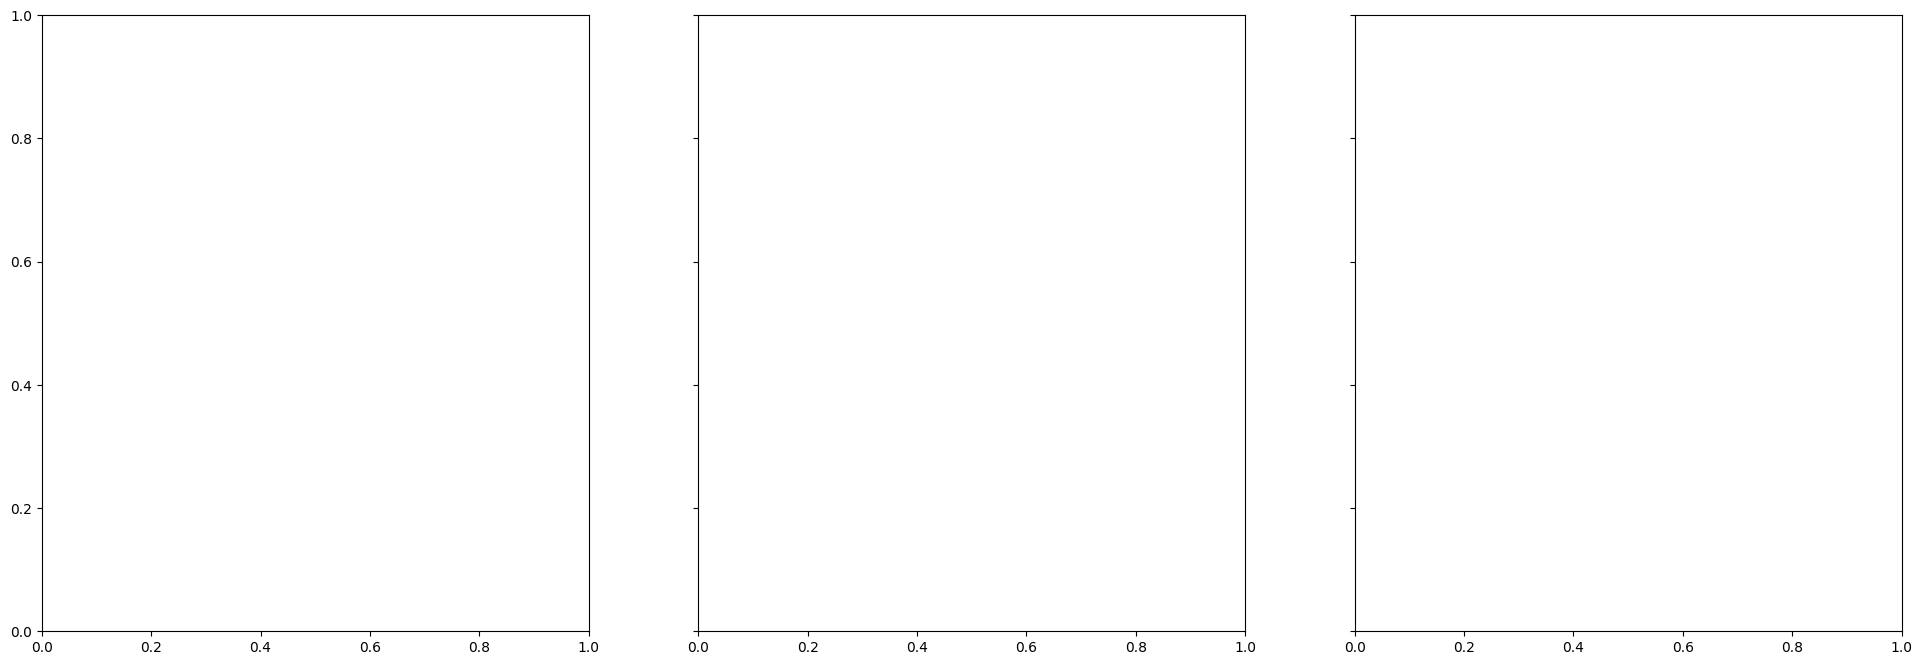

In [15]:
# Create a side-by-side comparison of all three layer types
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
layer_types = ["attention", "mlp", "hidden"]
x = [i for i in range(28)]

# Use different line styles and markers for different pairs
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']
markers = ['o', 's', '^', 'D', 'x', '+', '*', 'v', '>', '<']
colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))

# Calculate all distances once to avoid redundant calculations
all_distances = {}
for pair_idx, (input_type_1, input_type_2, name_1, name_2) in enumerate(pairs):
    pair_key = f"{name_1}_{name_2}"
    all_distances[pair_key] = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, intersection_keys)

# Plot each layer type in its own subplot
for ax_idx, value_type in enumerate(layer_types):
    ax = axes[ax_idx]
    
    for pair_idx, (input_type_1, input_type_2, name_1, name_2) in enumerate(pairs):
        pair_key = f"{name_1}_{name_2}"
        kld_list = all_distances[pair_key]
        
        # Plot the specified layer type
        ax.plot(x, kld_list[value_type], 
                label=f"{name_1} vs {name_2}",
                linestyle=line_styles[pair_idx % len(line_styles)],
                marker=markers[pair_idx % len(markers)],
                color=colors[pair_idx],
                linewidth=2,
                markersize=4)
    
    ax.set_xlabel('Layer', fontsize=12)
    if ax_idx == 0:
        ax.set_ylabel('Mean Distance (1 - cosine similarity)', fontsize=12)
    ax.set_title(f'{value_type.upper()} Distance', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)

# Add a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), 
           ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend at the bottom
plt.show()


In [ ]:
def plot_all_layers_by_block(pairs, keys, pair_indices=None):
    """
    Plot all layers with each block showing attention, MLP, and hidden states in order.
    
    Args:
        pairs: List of tuples (input_type_1, input_type_2, name_1, name_2)
        keys: List of keys to use for comparison
        pair_indices: List of indices to select which pairs to plot (default: all pairs)
    """
    # If no pair indices are provided, use all pairs
    if pair_indices is None:
        pair_indices = list(range(len(pairs)))
    
    # Select the pairs to plot
    selected_pairs = [pairs[i] for i in pair_indices]
    
    # Calculate distances for selected pairs
    all_distances = {}
    for input_type_1, input_type_2, name_1, name_2 in selected_pairs:
        pair_key = f"{name_1}_{name_2}"
        all_distances[pair_key] = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, intersection_keys)
    
    # Create x-axis labels for each block (attn, mlp, hidden)
    x_labels = []
    for layer in range(28):
        x_labels.extend([f"L{layer}-A", f"L{layer}-M", f"L{layer}-H"])
    
    # Create x-axis values
    x = np.arange(len(x_labels))
    
    # Create the figure
    plt.figure(figsize=(20, 10))
    
    # Use different colors for different pairs
    colors = plt.cm.tab10(np.linspace(0, 1, len(selected_pairs)))
    
    # Plot each pair
    for pair_idx, (input_type_1, input_type_2, name_1, name_2) in enumerate(selected_pairs):
        pair_key = f"{name_1}_{name_2}"
        distances = all_distances[pair_key]
        
        # Create y values and markers for each component
        y_values = []
        markers = []
        for layer in range(28):
            y_values.extend([
                distances["attention"][layer],
                distances["mlp"][layer],
                distances["hidden"][layer]
            ])
            markers.extend(['o', '^', 's'])  # Circle for attention, triangle for MLP, square for hidden
        
        # Plot the values with different markers for each component type
        for i, (x_val, y_val, marker) in enumerate(zip(x, y_values, markers)):
            plt.scatter(x_val, y_val, marker=marker, color=colors[pair_idx], s=40)
            
            # Connect points with lines, but only within the same pair
            if i > 0 and i % 3 != 0:  # Don't connect between different layers
                plt.plot([x[i-1], x_val], [y_values[i-1], y_val], color=colors[pair_idx], linewidth=1)
            elif i > 0 and i % 3 == 0 and i >= 3:  # Connect last point of previous layer to first point of current layer
                plt.plot([x[i-3], x_val], [y_values[i-3], y_val], color=colors[pair_idx], linewidth=1, linestyle='--', alpha=0.5)
    
    # Add vertical lines to separate layers
    for layer in range(1, 28):
        plt.axvline(x=layer*3 - 0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Set x-axis ticks and labels
    plt.xticks(x[::3], [f"Layer {i}" for i in range(28)], rotation=90)
    
    # Add minor ticks for each block
    ax = plt.gca()
    minor_ticks = x
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(x_labels, minor=True, rotation=90, fontsize=8)
    ax.tick_params(axis='x', which='minor', length=0)
    
    # Add grid, labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel('Mean Distance (1 - cosine similarity)', fontsize=12)
    plt.title('Layer-by-Layer Comparison of Attention, MLP, and Hidden States', fontsize=14)
    
    # Create legends
    # First legend: pairs
    pair_legend = plt.legend([plt.Line2D([0], [0], color=colors[i], lw=2) for i in range(len(selected_pairs))],
                            [f"{pairs[i][2]} vs {pairs[i][3]}" for i in pair_indices],
                            fontsize=10, loc='upper right')
    
    # Second legend: block types with appropriate markers
    custom_markers = [
        plt.Line2D([0], [0], color='black', lw=0, marker='o', markersize=8),
        plt.Line2D([0], [0], color='black', lw=0, marker='^', markersize=8),
        plt.Line2D([0], [0], color='black', lw=0, marker='s', markersize=8)
    ]
    plt.legend(custom_markers, ['A: Attention (circle)', 'M: MLP (triangle)', 'H: Hidden (square)'], 
               loc='upper left', fontsize=10, frameon=True)
    
    # Add the first legend back
    plt.gca().add_artist(pair_legend)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Example: Plot all layers with each block showing attention, MLP, and hidden states
# Using the first 3 pairs for clarity
plot_all_layers_by_block(pairs, intersection_keys, pair_indices=[0, 1, 2, 3, 4, 5, 6,7,8, 9])


In [ ]:
def plot_heatmap_by_block(pair_idx, pairs, keys):
    """
    Plot a heatmap visualization of attention, MLP, and hidden states across all layers.
    
    Args:
        pair_idx: Index of the pair to visualize
        pairs: List of tuples (input_type_1, input_type_2, name_1, name_2)
        keys: List of keys to use for comparison
    """
    # Get the pair
    input_type_1, input_type_2, name_1, name_2 = pairs[pair_idx]
    
    # Calculate distances
    distances = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, keys)
    
    # Create data for heatmap
    data = np.zeros((3, 28))
    for layer in range(28):
        data[0, layer] = distances["attention"][layer]
        data[1, layer] = distances["mlp"][layer]
        data[2, layer] = distances["hidden"][layer]
    
    # Create figure
    plt.figure(figsize=(16, 6))
    
    # Plot heatmap
    im = plt.imshow(data, cmap='viridis', aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Mean Distance (1 - cosine similarity)', fontsize=12)
    
    # Set ticks and labels
    plt.yticks([0, 1, 2], ['Attention', 'MLP', 'Hidden'])
    plt.xticks(np.arange(28), [f"{i}" for i in range(28)])
    
    # Add grid
    plt.grid(False)
    
    # Add title and labels
    plt.title(f'Mean Distance Between {name_1} and {name_2} Representations', fontsize=14)
    plt.xlabel('Layer', fontsize=12)
    
    # Add text annotations with values
    for i in range(3):
        for j in range(28):
            plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", 
                     color="white" if data[i, j] > 0.5 else "black", fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_layers_by_block(pairs, keys, pair_indices=None):
    """
    Plot all layers with each block showing attention, MLP, and hidden states in order,
    with each pair in its own subplot and lines connecting the points.
    
    Args:
        pairs: List of tuples (input_type_1, input_type_2, name_1, name_2)
        keys: List of keys to use for comparison
        pair_indices: List of indices to select which pairs to plot (default: all pairs)
    """
    # If no pair indices are provided, use all pairs
    if pair_indices is None:
        pair_indices = list(range(len(pairs)))
    
    # Select the pairs to plot
    selected_pairs = [pairs[i] for i in pair_indices]
    
    # Calculate number of rows and columns for the grid
    n_pairs = len(selected_pairs)
    n_cols = min(3, n_pairs)
    n_rows = (n_pairs + n_cols - 1) // n_cols  # Ceiling division
    
    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(n_rows, n_cols, figure=fig)
    ax_list = []
    
    # Create subplots
    for i in range(n_pairs):
        row, col = i // n_cols, i % n_cols
        ax = fig.add_subplot(gs[row, col])
        ax_list.append(ax)
    
    # Plot each pair in its own subplot
    for i, (input_type_1, input_type_2, name_1, name_2) in enumerate(selected_pairs):
        # Calculate distances
        distances = calculate_kld_mean_btw_input_types(input_type_1, input_type_2, intersection_keys)
        
        # Create x-axis labels for each block (attn, mlp, hidden)
        x_labels = []
        for layer in range(28):
            x_labels.extend([f"L{layer}-A", f"L{layer}-M", f"L{layer}-H"])
        
        # Create x-axis values
        x = np.arange(len(x_labels))
        
        # Create y values in the order of (attn, mlp, hidden) for each layer
        y_values = []
        for layer in range(28):
            y_values.extend([
                distances["attention"][layer],
                distances["mlp"][layer],
                distances["hidden"][layer]
            ])
        
        ax = ax_list[i]
        
        # Plot the line connecting all points
        ax.plot(x, y_values, color='black', linewidth=1, alpha=0.8)
        
        # Plot points with different markers for each component type
        for j in range(len(y_values)):
            component_type = j % 3  # 0: attention, 1: mlp, 2: hidden
            if component_type == 0:  # Attention
                marker = 'o'
                color = 'blue'
                label = "Attention" if j == 0 else None
            elif component_type == 1:  # MLP
                marker = '^'
                color = 'green'
                label = "MLP" if j == 1 else None
            else:  # Hidden
                marker = 's'
                color = 'red'
                label = "Hidden" if j == 2 else None
                
            ax.scatter(x[j], y_values[j], marker=marker, s=30, color=color, label=label)
        
        # Add vertical lines to separate layers
        for layer in range(1, 28):
            ax.axvline(x=layer*3 - 0.5, color='gray', linestyle='--', alpha=0.3)
        
        # Set x-axis ticks and labels
        ax.set_xticks(x[::3])
        ax.set_xticklabels([f"{i}" for i in range(28)], rotation=90, fontsize=8)
        
        ax.set_title(f'{name_1} vs {name_2}', fontsize=12)
        ax.set_xlabel('Layer', fontsize=10)
        ax.set_ylabel('Distance (1 - cosine similarity)', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=9)
        
        # Add legend to each subplot
        if i == 0:  # Only add legend to the first subplot
            ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_all_layers_by_block(pairs, intersection_keys, pair_indices=[i for i in range(len(pairs))])